In [211]:
!nrnivmodl "../nrn"

/Users/andrewlanpouthakoun/anaconda3/envs/stats220/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/usr/bin/xcrun
/Users/andrewlanpouthakoun/Desktop/FinalProject/CIP/STATS220-FINAL-PROJECT/src
Mod files: "../nrn/../nrn/capump.mod" "../nrn/../nrn/ingauss.mod" "../nrn/../nrn/mammalian_spike.mod" "../nrn/../nrn/mammalian_spike_35.mod" "../nrn/../nrn/xtra.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [213]:
from neuron import h
from hoc2swc import neuron2swc
import jaxley as jx

import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython.display import HTML

import functions_neuron as fn
import functions_jaxley as fj
import functions_helper as fh
from constants import LITKE_519_ARRAY_MAP
from constants import LITKE_519_ARRAY_GRID
N_ELECTRODES = LITKE_519_ARRAY_GRID.shape[0]

import importlib
importlib.reload(fn)
importlib.reload(fj)
importlib.reload(fh)

<module 'functions_helper' from '/Users/andrewlanpouthakoun/Desktop/FinalProject/CIP/STATS220-FINAL-PROJECT/src/functions_helper.py'>

[[-0.01194     0.          0.02      ]
 [-0.01227408  0.          0.02094255]
 [-0.01275496  0.          0.02181933]
 ...
 [-3.05527043  0.          0.03994091]
 [-3.05627043  0.          0.03994091]
 [-3.05727043  0.          0.03994091]]
[  -11.94         -12.27407655   -12.75496473 ... -3055.27042625
 -3056.27042625 -3057.27042625]


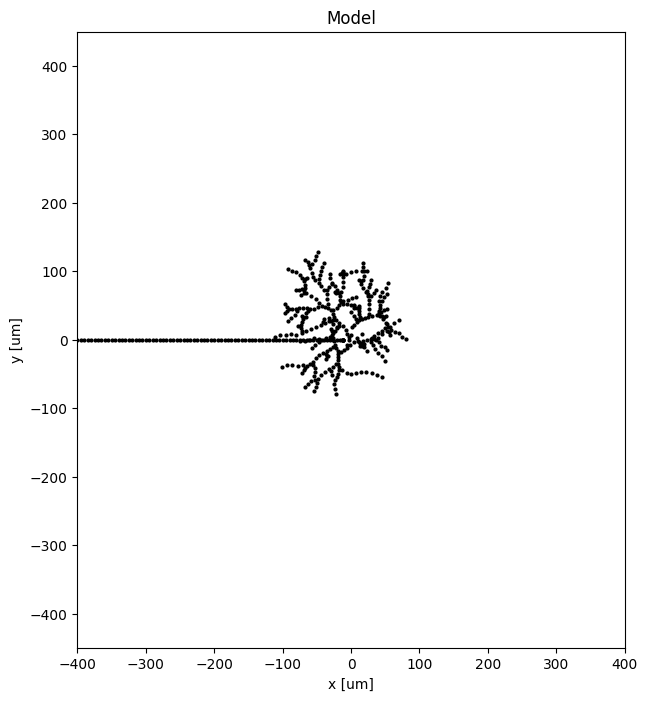

In [214]:
for sec in h.allsec():
   h.delete_section(sec=sec)
RGC, sec_lu = fn.generate_cell_neuron("params_35_v2.csv", "mammalian_spike_35")
fn.plot_cell_neuron(RGC)

In [215]:
neuron2swc("RGC_morph_4.swc")
cell = fj.generate_cell_groups_from_swc_jaxley("RGC_morph_4.swc", sec_lu)
cell.move_to(x=-12, y=0, z=-50, update_nodes=True) # Move the soma to [12, 0, -50], assuming the array is at z=0
compartment_surface_areas = fh.get_surface_areas(cell) * 10E-8 # Calculate surface areas in cm^2

Wrote cell 0 to RGC_morph_4.swc


/Users/andrewlanpouthakoun/anaconda3/envs/stats220/lib/python3.13/site-packages/jaxley/io/swc.py:478: UserWarning: You set `jx.read_swc(..., backend='custom')`. The `custom` option is deprecated and will be removed in `Jaxley` version `0.10.0`. Use `jx.read_swc(..., backend='graph')` instead. If you are experiencing issues with this SWC reader, please open a `New issue` on GitHub: https://github.com/jaxleyverse/jaxley/issues
  warn(


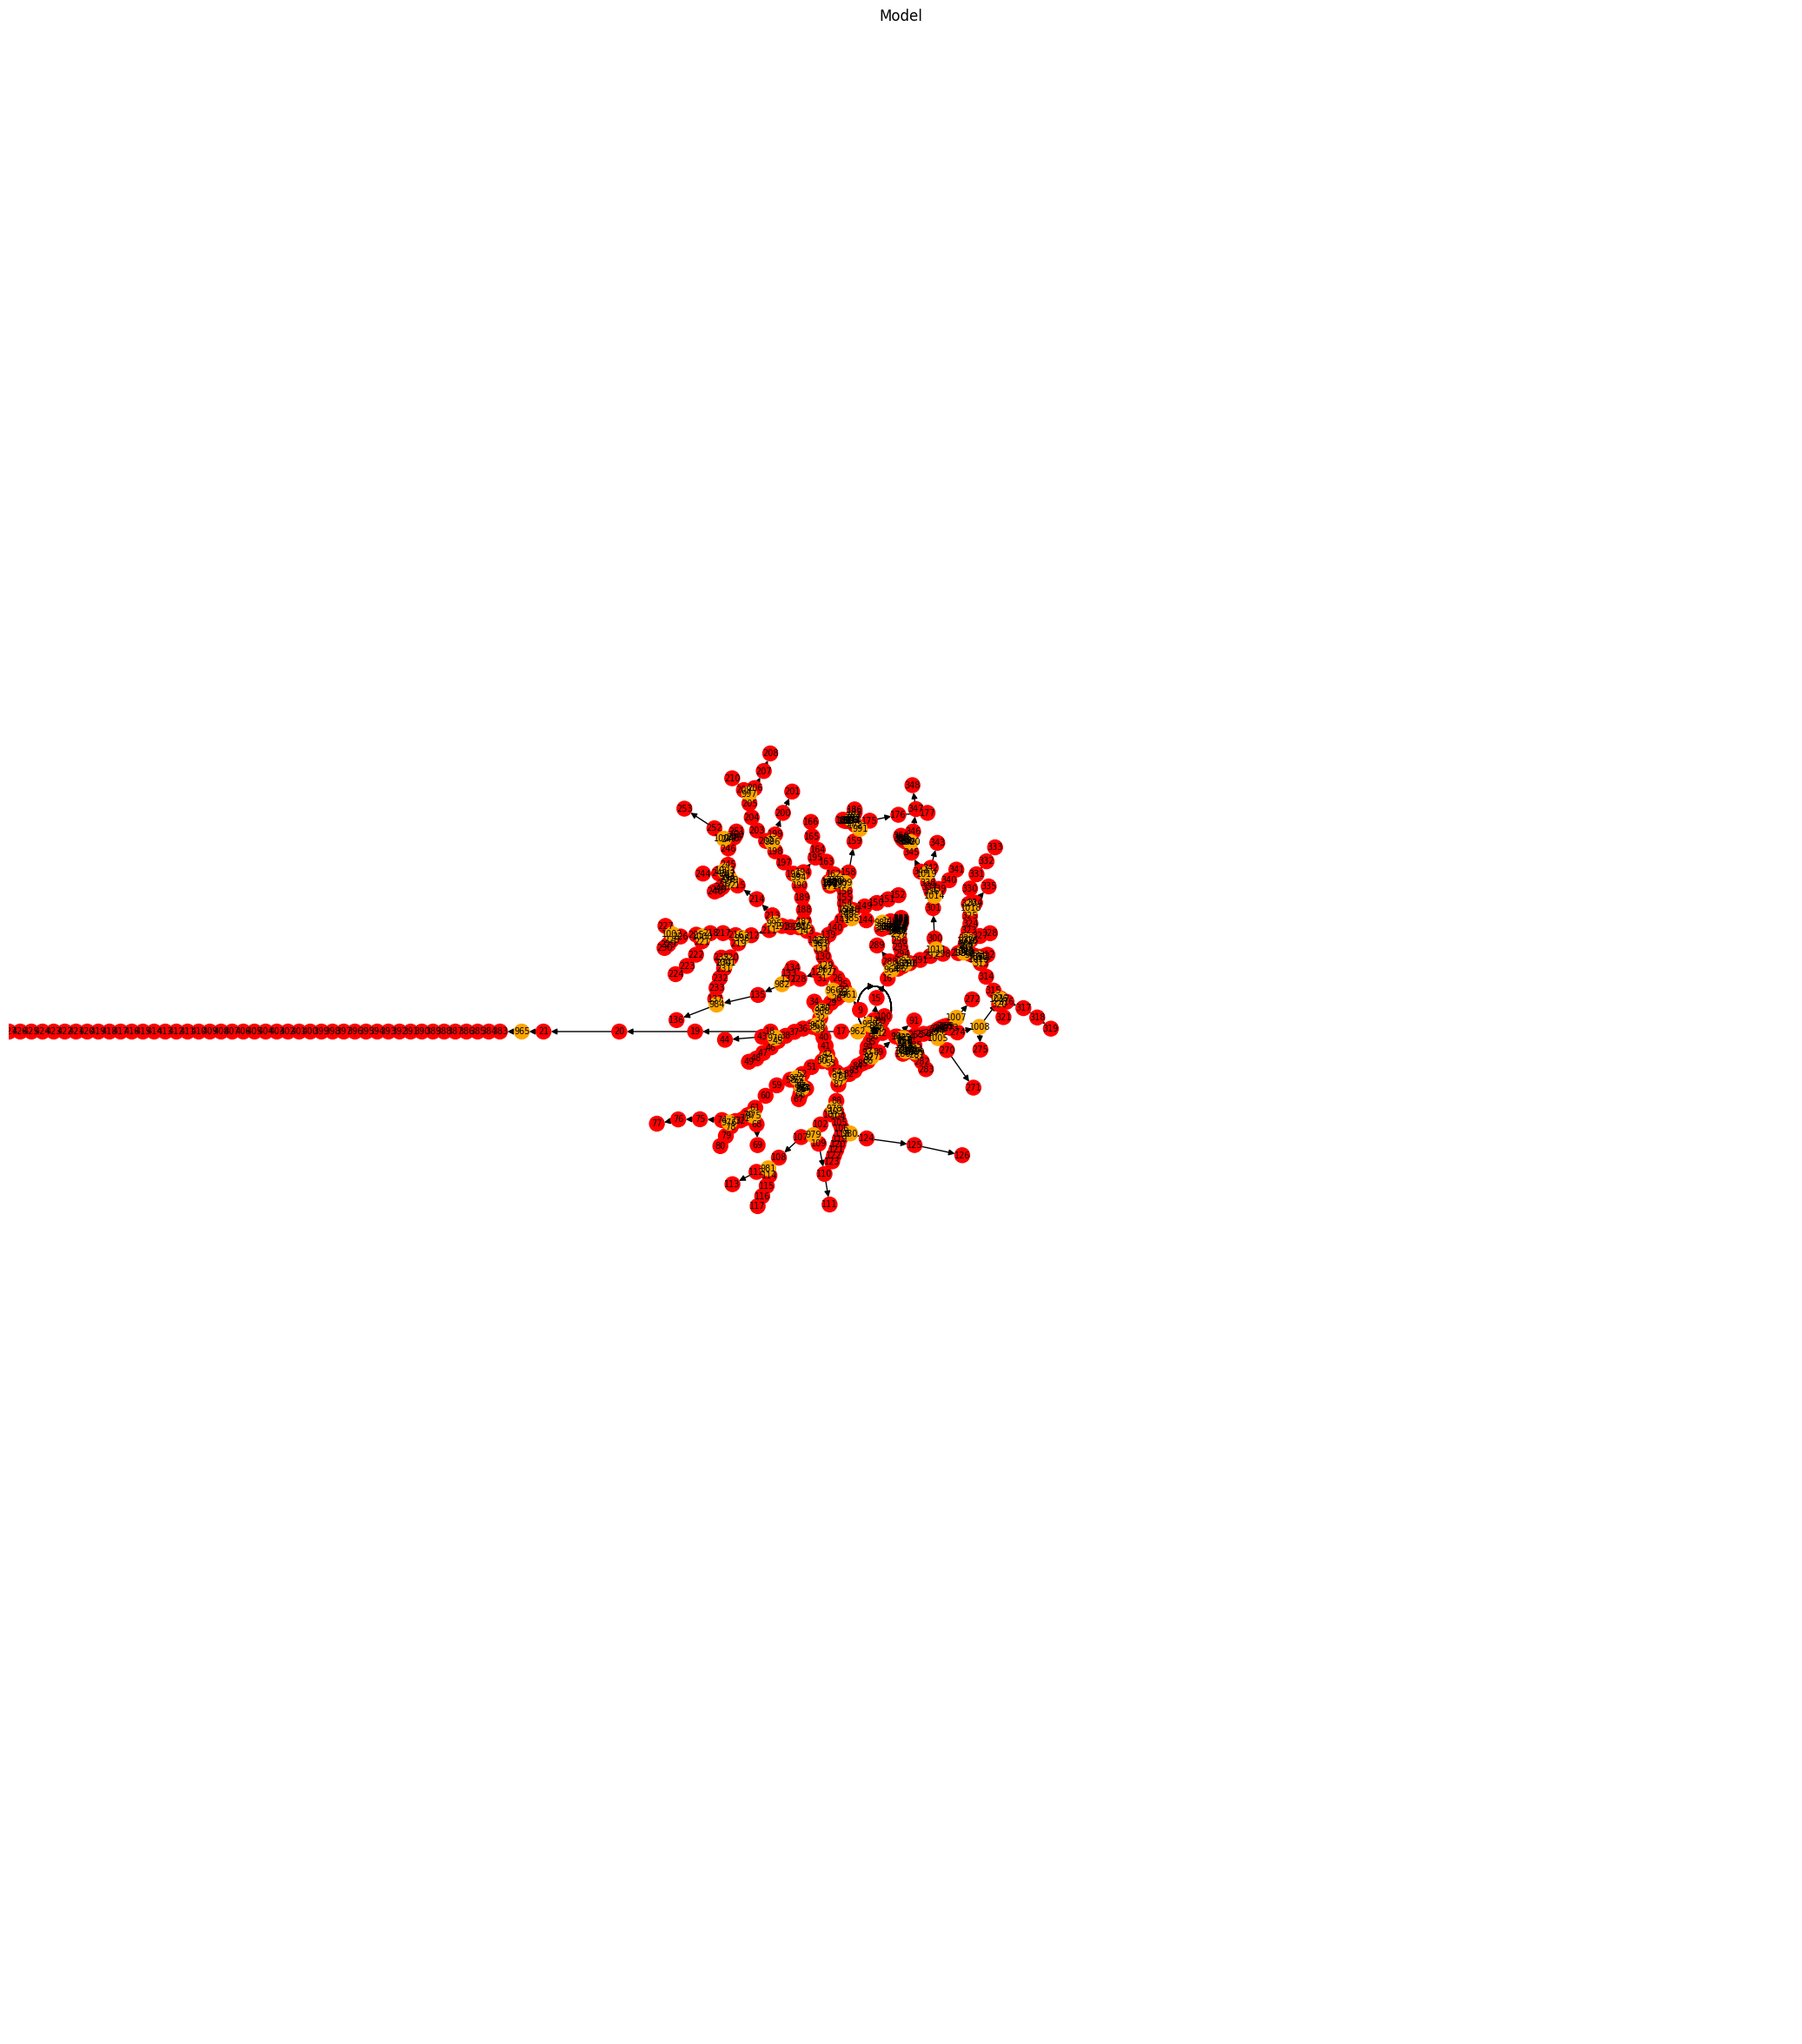

In [216]:
#fj.plot_cell_jaxley(cell, type="simple")
fj.plot_cell_jaxley(cell, type="full")
#cell.nodes.T

In [217]:
cell.insert(fj.HH())
cell.insert(fj.Ca())
cell.insert(fj.CaPump())
cell.insert(fj.CaNernstReversal())
cell.insert(fj.KCa())
cell.initialize()
# cell.nodes.T

Cell with 4 different channels. Use `.nodes` for details.

In [218]:
# TODO: Pull these values from the parameters file

### general parameters
cell.set("HH_eNa",60.6)
cell.set("HH_eK",-101.34)
cell.set("HH_eLeak",-64.58)
cell.set('axial_resistivity', 143.2)
cell.set("v",-65.02069782)

### Assign conductances

### Soma
cell.soma.set('HH_gLeak',0.0001)
cell.soma.set('HH_gNa',0.06)
cell.soma.set('HH_gK',0.035)
cell.soma.set('gCa',0.00075)
cell.soma.set('gKCa',0.00017)

### Dendrite
cell.dend.set('HH_gLeak',0.0001)
cell.dend.set('HH_gNa',0.06)
cell.dend.set('HH_gK',0.035)
cell.dend.set('gCa',0.001)
cell.dend.set('gKCa',0.00017)

### Axon Hillock
cell.AH.set('HH_gLeak',0.0001)
cell.AH.set('HH_gNa',0.15)
cell.AH.set('HH_gK',0.09)
cell.AH.set('gCa',0.00075)
cell.AH.set('gKCa',0.00017)

### Sodium Channel Band
cell.SOCB.set('HH_gLeak',0.0001)
cell.SOCB.set('HH_gNa',0.42)
cell.SOCB.set('HH_gK',0.25)
cell.SOCB.set('gCa',0.00075)
cell.SOCB.set('gKCa',0.00011)

### Narrow Axon
cell.NR.set('HH_gLeak',0.0001)
cell.NR.set('HH_gNa',0.1)
cell.NR.set('HH_gK',0.05)
cell.NR.set('gCa',0.00075)
cell.NR.set('gKCa',0.0002)

### Distal Axon
cell.axon.set('HH_gLeak',0.0001)
cell.axon.set('HH_gNa',0.1)
cell.axon.set('HH_gK',0.05)
cell.axon.set('gCa',0.00075)
cell.axon.set('gKCa',0.0002)

cell.initialize()
cell.init_states()
cell.nodes.T
n_compartments = cell.shape[1]

In [236]:
# Set up the default simulation

delta_t = 0.05 # ms
t_max = 5
time_vec = np.arange(0, t_max+2*delta_t, delta_t)

i_delay = 1.0 
i_dur = 0.5
i_amp = 3.9
current = jx.step_current(i_delay=i_delay, i_dur=i_dur, i_amp=i_amp, delta_t=delta_t, t_max=t_max)


cell.delete_stimuli()
cell.branch(0).comp(0).stimulate(current)

cell.delete_recordings()
cell.record("v")
cell.record("i_HH")
cell.record("i_Ca")
cell.record("i_KCa")

sim_outputs_original = jx.integrate(cell).reshape(4, n_compartments, -1)

Added 1 external_states. See `.externals` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.


In [237]:
# Set up the default simulation

delta_t = 0.05 # ms
t_max = 5
time_vec = np.arange(0, t_max+2*delta_t, delta_t)

i_delay = 1.0 
i_dur = 0.5
i_amp = 3.9
current = jx.step_current(i_delay=i_delay, i_dur=i_dur, i_amp=i_amp, delta_t=delta_t, t_max=t_max)


cell.delete_stimuli()
data_stimuli = None
data_stimuli = cell.branch(0).comp(0).data_stimulate(current)

# cell.delete_stimuli()
# cell.branch(0).comp(0).stimulate(current)

cell.delete_recordings()
cell.record("v")
cell.record("i_HH")
cell.record("i_Ca")
cell.record("i_KCa")

sim_outputs = jx.integrate(cell, params= params, data_stimuli=data_stimuli).reshape(4, n_compartments, -1)

Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.


In [238]:
jnp.allclose(sim_outputs, sim_outputs_original)

Array(True, dtype=bool)

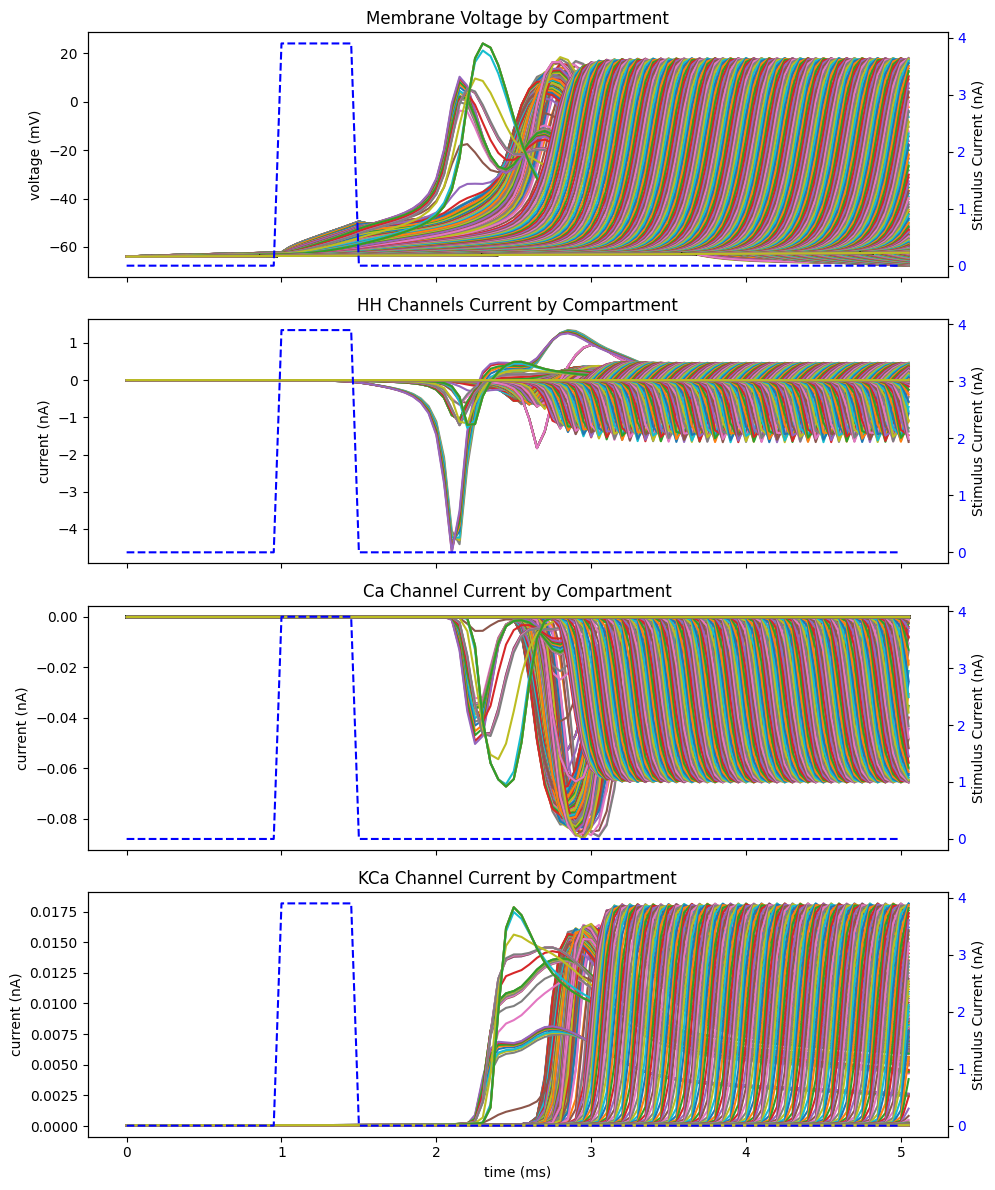

In [235]:
# Create a 4-panel subplot to visualize the results
fh.plot_default_simulation_output(sim_outputs, current, time_vec)

In [10]:
# Should be called every time the cell is updated
current_compartment_positions = fh.compute_comp_xyz(cell)
current_distances = fh.distance(LITKE_519_ARRAY_GRID, current_compartment_positions) * 10E-4 # Current distances between compartments and electrodes in cm

In [11]:
from jax import random
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
seed = random.PRNGKey(0)

sim_v_extra = fh.compute_eap(sim_outputs, current_distances, compartment_surface_areas) \
             + tfd.Normal(0,0.0001).sample((N_ELECTRODES, len(time_vec)), seed=seed)
sim_EI = fh.with_ttl(sim_v_extra).T

/Users/andrewlanpouthakoun/anaconda3/envs/stats220/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


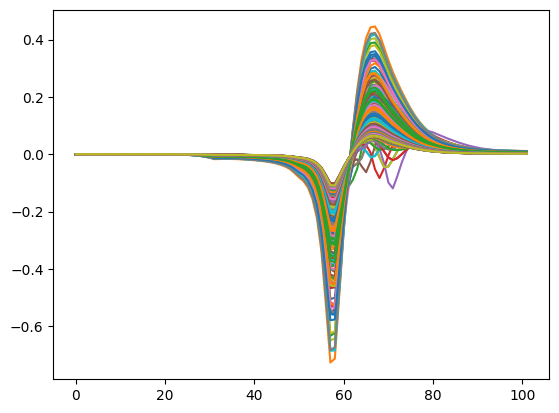

In [12]:
for i in range(N_ELECTRODES):
    plt.plot(sim_v_extra[i, :])

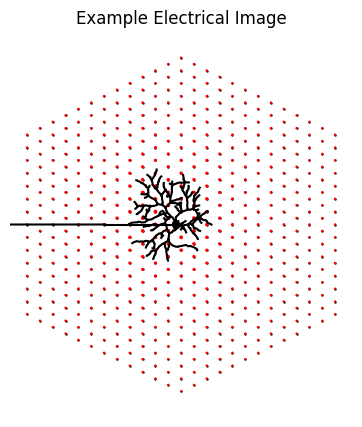

In [13]:
fh.plot_static_ei_519(sim_EI, title="Example Electrical Image", cell=cell)

In [14]:
# Plot an example animated EI

anim = fh.animate_519_array(sim_EI, title="Example Electrical Image", presentable=True, cell=cell)
HTML(fh._anim_to_html(anim, fps=10))

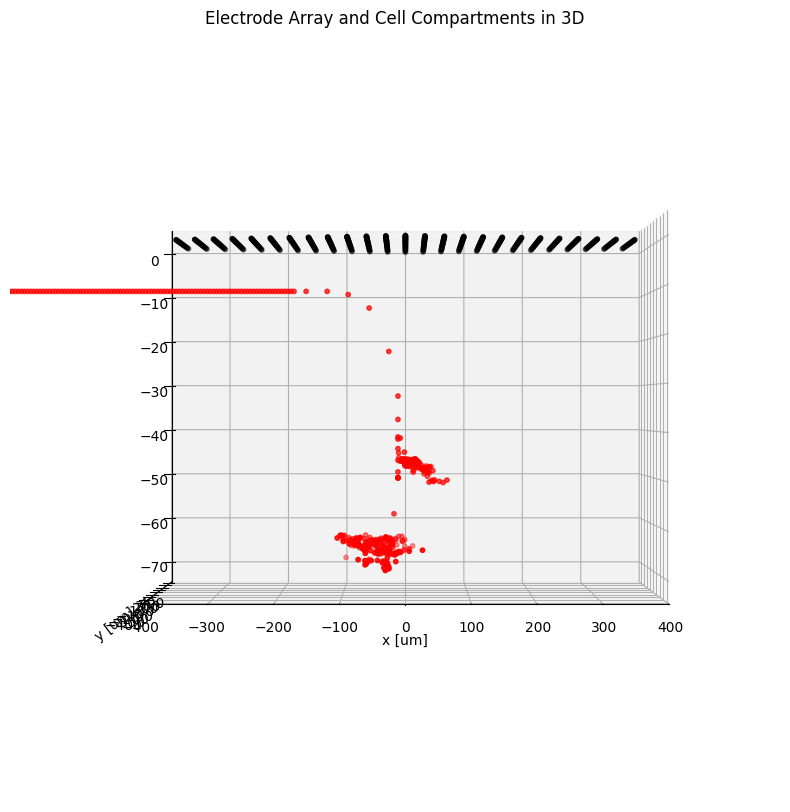

In [15]:
# Scatter the electrode array and the cell in 3D
fh.plot_cell_array_3D(current_compartment_positions, LITKE_519_ARRAY_GRID)

In [147]:
cell.delete_trainables()
cell.comp("all").make_trainable("x")
cell.comp("all").make_trainable("y")
cell.comp("all").make_trainable("z")
cell.comp("all").make_trainable("radius")

Number of newly added trainable parameters: 959. Total number of trainable parameters: 959
Number of newly added trainable parameters: 959. Total number of trainable parameters: 1918
Number of newly added trainable parameters: 959. Total number of trainable parameters: 2877
Number of newly added trainable parameters: 959. Total number of trainable parameters: 3836


In [184]:
# my_dict = dict(params)
import pickle as pkl

with open('./electrical_image_dataset/cell_41_ei.pkl', 'rb') as f:
    ei_example = pkl.load(f)
params = cell.get_parameters()


In [159]:
cell.get_all_parameters()

TypeError: Module.get_all_parameters() missing 1 required positional argument: 'pstate'

In [149]:
print(cell.nodes["length"])
print(params[-1])

0      0.020000
1      0.020000
2      0.020000
3      0.020000
4      0.020000
         ...   
954    5.000002
955    5.000002
956    5.000002
957    5.000002
958    5.000002
Name: length, Length: 959, dtype: float64
{'radius': Array([1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 4.24513388e+00, 1.00000000e+01, 1.00000000e+01,
       7.03233337e+00, 1.65763450e+00, 7.14710426e+00, 1.88392508e+00,
       1.20176816e+00, 2.00000000e+00, 1.63971102e+00, 8.16178977e-01,
       7.50000000e-01, 7.50000000e-01, 4.85583353e+00, 4.30749989e+00,
       3.75916672e+00, 4.49801350e+00, 4.78600740e+00, 4.96677828e+00,
       3.23960996e+00, 2.86843085e+00, 2.65823984e+00, 6.78602338e-01,
       2.78669167e+00, 1.47429419e+00, 2.32403681e-01, 1.38380694e+00,
       1.99788973e-01, 1.71253219e-01, 5.59352636e-01, 2.54795003e+00,
       1.93226027e+00, 1.64919639e+00, 2.56221604e+00, 4.0676

In [271]:
import train
importlib.reload(train)


trainer = train.JaxleyTrainer(cell, ei_example, 4, params)

Number of newly added trainable parameters: 959. Total number of trainable parameters: 959
Number of newly added trainable parameters: 959. Total number of trainable parameters: 1918
Number of newly added trainable parameters: 959. Total number of trainable parameters: 2877
Number of newly added trainable parameters: 959. Total number of trainable parameters: 3836
Number of newly added trainable parameters: 959. Total number of trainable parameters: 4795
Number of newly added trainable parameters: 959. Total number of trainable parameters: 5754
Number of newly added trainable parameters: 959. Total number of trainable parameters: 6713
Number of newly added trainable parameters: 959. Total number of trainable parameters: 7672


In [272]:
an = trainer.train()

Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Added 959 recordings. See `.recordings` for details.
Epoch 0, Loss 2.0983588695526123, Grad Norm: 21.60605239868164
epoch 0, loss 2.0983588695526123
Epoch 1, Loss 2.0687105655670166, Grad Norm: 14.917104721069336
epoch 1, loss 2.0687105655670166
Epoch 2, Loss 2.0389010906219482, Grad Norm: 3.19047212600708
epoch 2, loss 2.0389010906219482
Epoch 3, Loss 2.0444788932800293, Grad Norm: 3.0369679927825928
epoch 3, loss 2.0444788932800293
Epoch 4, Loss 2.000303030014038, Grad Norm: 12.446650505065918
epoch 4, loss 2.000303030014038
Epoch 5, Loss 1.9848120212554932, Grad Norm: nan
epoch 5, loss 1.9848120212554932
Epoch 6, Loss nan, Grad Norm: nan
epoch 6, loss nan
Epoch 7, Loss nan, Grad Norm: nan
epoch 7, loss nan
Epoch 8, Loss nan, Grad Norm: nan
epoch 8, loss nan
Epoch 9, Loss nan, Grad Norm: nan
epoch 9, loss nan
Added 959 recordin

/Users/andrewlanpouthakoun/anaconda3/envs/stats220/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [268]:
HTML(fh._anim_to_html(an, fps=10))